# QF600 - Homework 5
*by Julian Chang*


> ## Stochastic Discount Factor

- pricing kernel
- equity premium puzzle
- consumption growth
- rare disasters

In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

> Suppose that consumption growth has lognormal distribution with the possibility of rare disasters:
>$$\ln{\tilde{g}} = 0.02 + 0.02 \tilde{\epsilon} + \tilde{\nu} $$
> Here ε is a standard normal random variable, while ν is an independent random variable that has value of either zero (with probability of 98.3%) or ln(0.65) (with probability of 1.7%).
> Simulate ε with (at least) 10^4 random draws from standard normal distribution, and simulate ν with (at least) 10^4 random draws from standard uniform distribution.




`0.02` term is mean growth of consumption \
$\tilde{\epsilon}$ is the log normal randomness of consumption\
$\tilde{\nu}$ is rare disaster effect


In [2]:
def estimate_pricing_kernel(size: int, p_nu: float, phi: float, gamma: float)-> tuple:
    """
    Estimates the pricing kernel statistics: mean, standard deviation, and ratio of std dev to mean.
    
    Parameters:
        size (int): Number of samples to generate.
        p_nu (float): Probability of shock occurrence (`nu`).
        phi (float): Scaling parameter for shock impact.
        gamma (float): Risk aversion parameter.

    Returns:
        mean_M (mean of pricing kernel), 
        sig_M (standard deviation of pricing kernel), 
        sig_M_over_mean_M (ratio of std dev to mean).
    """
    epsilon = np.random.standard_normal(size)
    nu = np.random.choice([1,0], size=size, p=[p_nu,1-p_nu]) * np.log(phi)


    ln_g = .02 + .02 * epsilon + nu
    est_M = 0.99*np.power(np.exp(ln_g),-gamma)

    mean_M = np.mean(est_M)
    sig_M = np.std(est_M)
    sig_M_over_mean_M = sig_M / mean_M

    return mean_M, sig_M, sig_M_over_mean_M




>Use the simulated distribution of consumption growth to find the simulated distribution of the pricing kernel for power utility:
>$$\tilde{M} = 0.99 \tilde{g}^{-\gamma}$$
>Repeat this process for values of $\gamma$ in the range from 1 to 4, in increments of 0.1 (or less). (You can reuse the same simulated distribution of consumption growth for all values of $\gamma$)
>- Calculate the mean ($\mu_M$) and standard deviation ($\sigma_M$) of pricing kernel for each value of $\gamma$, and plot the volatility ratio (σM/μM) on the vertical axis vs $\gamma$ on the horizontal axis.
>- Find the smallest value of $\gamma$ (in your data) for which $\frac{\sigma_M}{\mu_M}$ > 0.4. 

$\tilde{M}$ is Pricing Kernel \
$\tilde{g}$ is consumption growth \
$\gamma$ is parameter of power utility \
#### Consumption CAPM model
$$
E[R_i] - R_f = -\frac{Cov(\tilde{R_i}, \tilde{M})}{E[\tilde{M}]} = -\frac{Cov(U'(\tilde{C_1^*}), \tilde{R_i})}{E[U'(\tilde{C_1^*})]}
$$

#### Power Utility
Consider investor with power utility of consumption:
$$
\tilde{M} = \delta \left(\frac{\tilde{C_1^*}}{C_0^*} \right)^{-\gamma}
$$
Apply result for variance of pricing kernel to volatility ratio:

$$
\frac{\sigma_M}{\mu_M} = \sqrt{\frac{\mu_M^2-1}{\mu_M^2}}
$$

Substitute for μM and μM2 in equation for volatility ratio of pricing kernel, and apply ex ≈ 1 + x for small values of x and Now substitute into result for H–J bound::
$$
\frac{\sigma_M}{\mu_M} \approx \gamma \sigma_c \geq \left|\frac{E[\tilde{R_i}] - R_f}{\sigma_i}\right|_{H-J Bound}
$$
*Assumptions* - allow $\mathbb{E}[\tilde{M}] = R_f^{-1}$ and $Cov[\tilde{M}, \tilde{R_i}] = \rho \sigma_M \sigma_i$ where $\rho$ is correlation of M and R

The smallest value of gamma for which sig_M/mu_M > 0.4 is: 3.3533834586466162


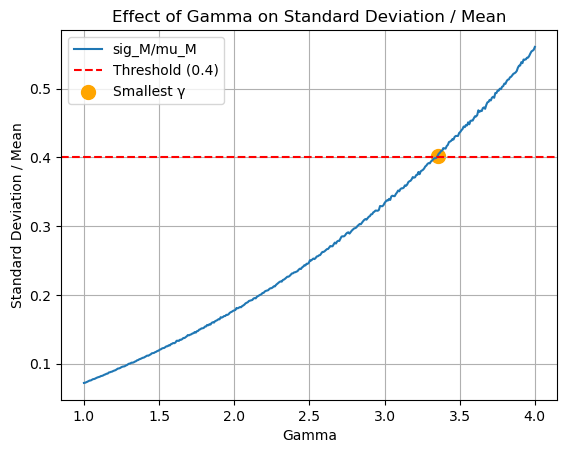

In [3]:
size        = 10**6
p_nu        = .017
phi         = .65
arr_gamma   = np.linspace(1,4,400)

# Generate results for gamma values from 1 to 4
results_df = pd.DataFrame(columns=['Gamma', 'Mean_M', 'Sig_M', 'Sig_M_over_Mean_M'])

for gamma in arr_gamma:
    mean_M, sig_M, sig_M_over_mean_M = estimate_pricing_kernel(size, p_nu, phi, gamma)
    # Create a temporary DataFrame for the current result
    temp_df = pd.DataFrame({
        'Gamma': [gamma],
        'Mean_M': [mean_M],
        'Sig_M': [sig_M],
        'Sig_M_over_Mean_M': [sig_M_over_mean_M]
    })
    # Concatenate the temporary DataFrame to results_df
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Find the smallest gamma where Sig_M_over_Mean_M > 0.4
threshold = 0.4
condition_met = results_df[results_df['Sig_M_over_Mean_M'] > threshold]
smallest_gamma = condition_met['Gamma'].iloc[0] if not condition_met.empty else None

# Display the smallest gamma
print(f"The smallest value of gamma for which sig_M/mu_M > 0.4 is: {smallest_gamma}")

# Plotting the last output against gamma
plt.plot(results_df['Gamma'], results_df['Sig_M_over_Mean_M'], label='sig_M/mu_M')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (0.4)')
if smallest_gamma is not None:
    plt.scatter(smallest_gamma, results_df['Sig_M_over_Mean_M'].iloc[condition_met.index[0]], color='orange', s=100, label='Smallest γ')
plt.xlabel('Gamma')
plt.ylabel('Standard Deviation / Mean')
plt.title('Effect of Gamma on Standard Deviation / Mean')
plt.legend()
plt.grid()
plt.show()

>Explain (in words, without using mathematical equations or formulas) the economic significance of this result.

The results show that investors must account for potential economic disruptions caused by rare disasters, which greatly increase consumption growth changes. Considering Consumption CAPM and H-J bound there is an equity premium puzzle where an unreasonably high degree of (relative) risk aversion is given by gamma greater than 20. However by including rare disasters, it is demonstrated that a moderate level of risk aversion can explain the higher-than-expected returns on equities where gamma is more reasonably around 3.3. Also, it underscores the importance of considering historical data in light of these disruptions, as excluding outliers them can lead to misleading interpretations of stability.